In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

data_dir = "COVID-19_Radiography_Dataset"
def count_images():
    class_counts = {}
    for cls in ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]:
        class_dir = os.path.join(data_dir, cls)
        img_dir = os.path.join(class_dir, "images")
        
        if os.path.exists(img_dir):
            files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[cls] = len(files)
        else:
            files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[cls] = len(files)
            
    return class_counts

class_counts = count_images()
print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.3  
)



Class distribution:
COVID: 3616 images
Normal: 10192 images
Viral Pneumonia: 1345 images
Lung_Opacity: 6012 images


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset path
data_dir = "COVID-19_Radiography_Dataset"

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64  

classes = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    validation_split=0.3  # 70% training, 30% validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='training',  
    shuffle=True,
    seed=42  
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='validation',  
    shuffle=False,
    seed=42  
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class mapping: {train_generator.class_indices}")

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.
Training samples: 29632
Validation samples: 12698
Number of classes: 4
Class mapping: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_HEIGHT, IMG_WIDTH = 224, 224

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0  )

print(f"Base model: {base_model.name}")
print(f"Input shape: {base_model.input_shape}")
print(f"Output shape: {base_model.output_shape}")

Base model: mobilenetv2_1.00_224
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)


In [4]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

NUM_CLASSES = 4  
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(NUM_CLASSES, activation='softmax')(x)  # softmax for multi-class classification
model = Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [5]:
print("Model Summary:")
model.summary()
total_params = model.count_params()
print(f"\nTotal number of parameters: {total_params:,}")
print("\nLayers with their associated parameters:")
for layer in model.layers:
    if layer.name == base_model.name:
        print(f"Base model ({layer.name}):")
        for base_layer in base_model.layers:
            print(f"  {base_layer.name}: {base_layer.count_params():,} parameters")
    else:
        print(f"{layer.name}: {layer.count_params():,} parameters")

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)


Total number of parameters: 4,096,580

Layers with their associated parameters:
input_layer: 0 parameters
Conv1: 864 parameters
bn_Conv1: 128 parameters
Conv1_relu: 0 parameters
expanded_conv_depthwise: 288 parameters
expanded_conv_depthwise_BN: 128 parameters
expanded_conv_depthwise_relu: 0 parameters
expanded_conv_project: 512 parameters
expanded_conv_project_BN: 64 parameters
block_1_expand: 1,536 parameters
block_1_expand_BN: 384 parameters
block_1_expand_relu: 0 parameters
block_1_pad: 0 parameters
block_1_depthwise: 864 parameters
block_1_depthwise_BN: 384 parameters
block_1_depthwise_relu: 0 parameters
block_1_project: 2,304 parameters
block_1_project_BN: 96 parameters
block_2_expand: 3,456 parameters
block_2_expand_BN: 576 parameters
block_2_expand_relu: 0 parameters
block_2_depthwise: 1,296 parameters
block_2_depthwise_BN: 576 parameters
block_2_depthwise_relu: 0 parameters
block_2_project: 3,456 parameters
block_2_project_BN: 96 parameters
block_2_add: 0 parameters
block_3_e

Starting transfer learning with different configurations...

Training configuration: two_conv_three_fc
Total layers: 158, Trainable layers: 22


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7014 - loss: 0.7600

463/463 ━━━━━━━━━━━━━━━━━━━━ 1834s 4s/step - accuracy: 0.7015 - loss: 0.7598 - val_accuracy: 0.7831 - val_loss: 1.0702
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8004 - loss: 0.5214

463/463 ━━━━━━━━━━━━━━━━━━━━ 1539s 3s/step - accuracy: 0.8004 - loss: 0.5214 - val_accuracy: 0.8135 - val_loss: 0.7709
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8136 - loss: 0.4808

463/463 ━━━━━━━━━━━━━━━━━━━━ 1789s 4s/step - accuracy: 0.8136 - loss: 0.4809 - val_accuracy: 0.8641 - val_loss: 0.4787
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 1105s 2s/step - accuracy: 0.8275 - loss: 0.4448 - val_accuracy: 0.8253 - val_loss: 0.6859
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8337 - loss: 0.4290

463/463 ━━━━━━━━━━━━━━━━━━━━ 2310s 5s/step - accuracy: 0.8337 - loss: 0.4290 - val_accuracy: 0.8833 - val_loss: 0.4107
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8417 - loss: 0.4150

463/463 ━━━━━━━━━━━━━━━━━━━━ 2116s 5s/step - accuracy: 0.8417 - loss: 0.4150 - val_accuracy: 0.8871 - val_loss: 0.3966
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8482 - loss: 0.3898

463/463 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.8482 - loss: 0.3898 - val_accuracy: 0.9088 - val_loss: 0.3473
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8571 - loss: 0.3622

463/463 ━━━━━━━━━━━━━━━━━━━━ 763s 2s/step - accuracy: 0.8571 - loss: 0.3622 - val_accuracy: 0.9053 - val_loss: 0.3462
Epoch 9/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 760s 2s/step - accuracy: 0.8665 - loss: 0.3450 - val_accuracy: 0.8730 - val_loss: 0.5389
Epoch 10/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 763s 2s/step - accuracy: 0.8749 - loss: 0.3230 - val_accuracy: 0.8999 - val_loss: 0.4205
Epoch 11/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 764s 2s/step - accuracy: 0.8833 - loss: 0.3058 - val_accuracy: 0.8721 - val_loss: 0.7890
Training time: 14632.50 seconds
199/199 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step  

Results for two_conv_three_fc:
Accuracy: 0.9053
Recall: 0.8853
Precision: 0.9270
F1-Score: 0.9044
Sensitivity: 0.8853

Training configuration: one_conv_three_fc
Total layers: 158, Trainable layers: 14
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6950 - loss: 0.8091

463/463 ━━━━━━━━━━━━━━━━━━━━ 751s 2s/step - accuracy: 0.6951 - loss: 0.8088 - val_accuracy: 0.7280 - val_loss: 1.4479
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7942 - loss: 0.5294

463/463 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.7942 - loss: 0.5294 - val_accuracy: 0.8431 - val_loss: 0.5373
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8139 - loss: 0.4841

463/463 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.8139 - loss: 0.4841 - val_accuracy: 0.8849 - val_loss: 0.4247
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8197 - loss: 0.4651

463/463 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.8197 - loss: 0.4651 - val_accuracy: 0.9101 - val_loss: 0.3280
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.8294 - loss: 0.4409 - val_accuracy: 0.8474 - val_loss: 0.6257
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.8369 - loss: 0.4212 - val_accuracy: 0.8556 - val_loss: 0.5389
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.8414 - loss: 0.4061 - val_accuracy: 0.9043 - val_loss: 0.3580
Training time: 5130.81 seconds
199/199 ━━━━━━━━━━━━━━━━━━━━ 198s 989ms/step

Results for one_conv_three_fc:
Accuracy: 0.9101
Recall: 0.8974
Precision: 0.9296
F1-Score: 0.9123
Sensitivity: 0.8974

Training configuration: only_three_fc
Total layers: 158, Trainable layers: 4
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6763 - loss: 0.8588

463/463 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.6764 - loss: 0.8585 - val_accuracy: 0.8336 - val_loss: 0.4473
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7592 - loss: 0.6057

463/463 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.7592 - loss: 0.6057 - val_accuracy: 0.8675 - val_loss: 0.3532
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.7808 - loss: 0.5568 - val_accuracy: 0.8671 - val_loss: 0.3581
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.7877 - loss: 0.5319 - val_accuracy: 0.8510 - val_loss: 0.4183
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.7965 - loss: 0.5121 - val_accuracy: 0.8661 - val_loss: 0.3633
Training time: 3607.21 seconds
199/199 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step

Results for only_three_fc:
Accuracy: 0.8675
Recall: 0.8518
Precision: 0.8846
F1-Score: 0.8659
Sensitivity: 0.8518


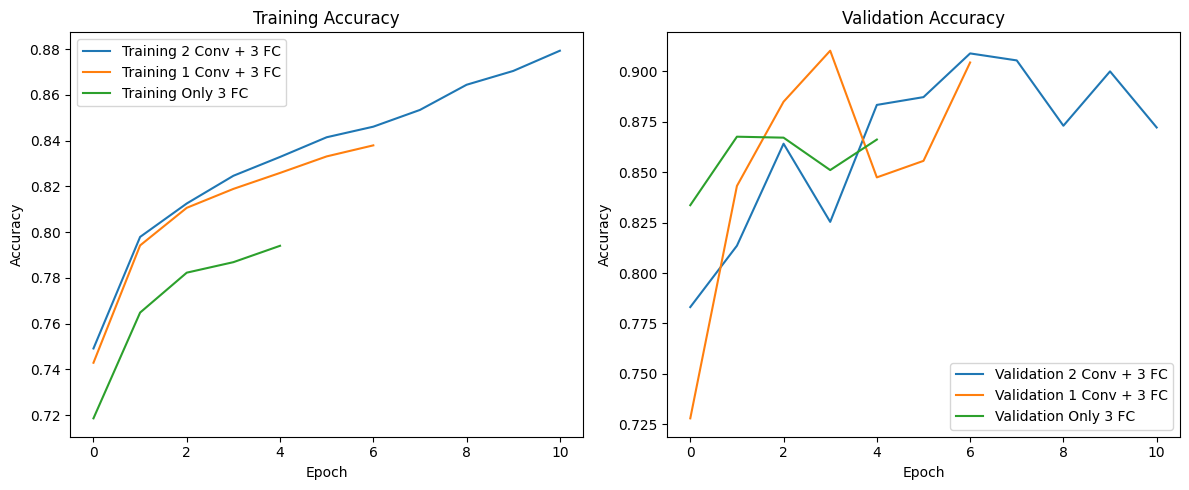

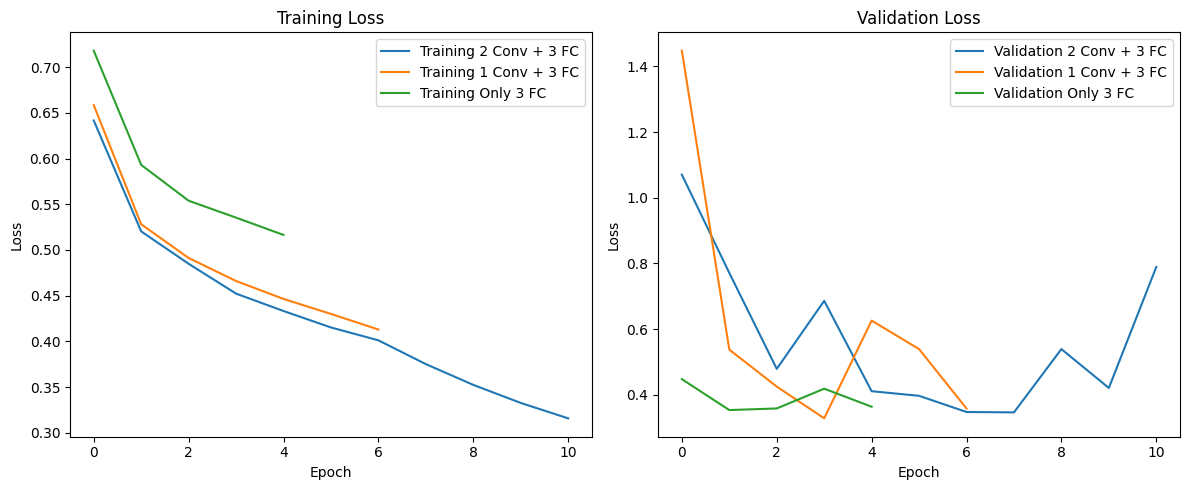


Comparison of Results:
--------------------------------------------------------------------------------
Configuration        Accuracy   Recall     Precision  F1-Score   Training Time  
--------------------------------------------------------------------------------
2 Conv + 3 FC        0.9053     0.8853     0.9270     0.9044     14632.50       s
1 Conv + 3 FC        0.9101     0.8974     0.9296     0.9123     5130.81        s
Only 3 FC            0.8675     0.8518     0.8846     0.8659     3607.21        s
--------------------------------------------------------------------------------


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def train_transfer_learning(config_name, num_conv_layers_to_train):
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet',
        alpha=1.0
    )
    
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze the last N convolutional layers based on the configuration
    if num_conv_layers_to_train > 0:
        # Find the index of layers to unfreeze
        # For MobileNetV2, the last convolutional blocks are near the end
        trainable_layers = []
        
        if num_conv_layers_to_train == 1:
            # Last block (block_16)
            trainable_layers = ['block_16_expand', 'block_16_depthwise', 'block_16_project', 'Conv_1']
        elif num_conv_layers_to_train == 2:
            # Last two blocks (block_15 and block_16)
            trainable_layers = [
                'block_15_expand', 'block_15_depthwise', 'block_15_project', 
                'block_16_expand', 'block_16_depthwise', 'block_16_project', 
                'Conv_1'
            ]
        
        # Set the identified layers to trainable
        for layer in base_model.layers:
            if any(trainable_name in layer.name for trainable_name in trainable_layers):
                layer.trainable = True
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    model.compile (
     optomizer = Adem(learning_rate=0.001),
     loss='categorical_crossentropy',
     metrics=['accuracy']
    )
    
    print(f"\nTraining configuration: {config_name}")
    trainable_count = sum(1 for layer in model.layers if layer.trainable)
    print(f"Total layers: {len(model.layers)}, Trainable layers: {trainable_count}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'best_model_{config_name}.h5', save_best_only=True)
    ]
    
    import time
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=callbacks,
        batch_size=64
    )
    
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
    
    y_pred = []
    y_true = []
    
    validation_generator.reset()
    
    steps = validation_generator.samples // validation_generator.batch_size + 1
    predictions = model.predict(validation_generator, steps=steps)
    y_pred = np.argmax(predictions, axis=1)[:validation_generator.samples]
    y_true = validation_generator.classes[:validation_generator.samples]
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    sensitivity = recall  # Sensitivity is same as recall for binary classification
    
    print(f"\nResults for {config_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    
    return history, model, training_time, {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'sensitivity': sensitivity,
        'training_time': training_time
    }

print("Starting transfer learning with different configurations...")

history1, model1, time1, metrics1 = train_transfer_learning(
    "two_conv_three_fc", 2
)

history2, model2, time2, metrics2 = train_transfer_learning(
    "one_conv_three_fc", 1
)

history3, model3, time3, metrics3 = train_transfer_learning(
    "only_three_fc", 0
)

import matplotlib.pyplot as plt

def plot_training_history(histories, labels, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f'Training {labels[i]}')
    plt.title(f'Training {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {labels[i]}')
    plt.title(f'Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{metric}_curves.png')
    plt.show()

plot_training_history(
    [history1, history2, history3],
    ['2 Conv + 3 FC', '1 Conv + 3 FC', 'Only 3 FC'],
    'accuracy'
)

plot_training_history(
    [history1, history2, history3],
    ['2 Conv + 3 FC', '1 Conv + 3 FC', 'Only 3 FC'],
    'loss'
)

results = {
    '2 Conv + 3 FC': metrics1,
    '1 Conv + 3 FC': metrics2,
    'Only 3 FC': metrics3
}

print("\nComparison of Results:")
print("-" * 80)
print(f"{'Configuration':<20} {'Accuracy':<10} {'Recall':<10} {'Precision':<10} {'F1-Score':<10} {'Training Time':<15}")
print("-" * 80)
for config, metrics in results.items():
    print(f"{config:<20} {metrics['accuracy']:<10.4f} {metrics['recall']:<10.4f} {metrics['precision']:<10.4f} {metrics['f1']:<10.4f} {metrics['training_time']:<15.2f}s")
print("-" * 80)